In [14]:
BASE_DIR = "/content/drive/MyDrive/AML_ass2"
LIST = f"{BASE_DIR}/list"

TRAIN_TXT = f"{LIST}/train.txt"
TEST_TXT  = f"{LIST}/test.txt"
GT_TXT    = f"{LIST}/groundtruth.txt"
SPECIES   = f"{LIST}/species_list.txt"
PAIR_TXT  = f"{LIST}/class_with_pairs.txt"
NOPAIR_TXT= f"{LIST}/class_without_pairs.txt"

# Clean species list
clean = []
with open(SPECIES) as f:
    for line in f:
        line = line.strip().replace(";", "")
        if line:
            clean.append(line)
with open(SPECIES, "w") as f:
    f.write("\n".join(clean))

# Build ID maps
id_to_name = {}
with open(SPECIES) as f:
    for line in f:
        cid, name = line.split(maxsplit=1)
        id_to_name[int(cid)] = name

all_ids = sorted(id_to_name.keys())
id_to_idx = {cid:i for i,cid in enumerate(all_ids)}
idx_to_id = {i:cid for cid,i in id_to_idx.items()}
idx_to_name = {i:id_to_name[idx_to_id[i]] for i in idx_to_id}

NUM_CLASSES = len(id_to_idx)
print("Total classes:", NUM_CLASSES)


Total classes: 100


In [31]:
train_paths, train_labels = [], []

with open(TRAIN_TXT) as f:
    for line in f:
        rel, cid = line.strip().split()
        full = os.path.join(BASE_DIR, rel)
        cid = int(cid)
        if cid in id_to_idx:
            train_paths.append(full)
            train_labels.append(id_to_idx[cid])

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

print("Training samples:", len(train_paths))

# -------- tf.data functions ----------
IMG_SIZE = 224
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_resize(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, 3)
    x = tf.image.resize(x, [IMG_SIZE, IMG_SIZE])
    return x

def augment(x):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, 0.2)
    return x

def make_train(paths, labels, preprocess_func):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def _load(p, y):
        x = decode_resize(p)
        x = augment(x)
        x = preprocess_func(x)
        return x, y
    return ds.shuffle(2048).map(_load, AUTOTUNE).batch(BATCH).prefetch(AUTOTUNE)

def make_test(paths, preprocess_func):
    labels = tf.constant(test_labels)   # <-- ALIGN LABELS WITH PATHS
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    def _load(p, y):
        x = decode_resize(p)
        x = preprocess_func(x)
        return x, y                     # <-- RETURN LABEL TOO
    return ds.map(_load, AUTOTUNE).batch(BATCH)


Training samples: 4744


In [16]:
def evaluate_model(model, test_paths, test_labels):
    probs = model.predict(test_ds)
    pred_top1 = probs.argmax(1)
    pred_top5 = np.argsort(-probs, axis=1)[:, :5]

    top1 = np.mean(pred_top1 == test_labels)
    top5 = np.mean([test_labels[i] in pred_top5[i] for i in range(len(test_labels))])

    return probs, pred_top1, pred_top5, top1, top5


def compute_pair_accuracy(pred_top1, pred_top5, test_labels):
    pair_ids = set(int(x.strip()) for x in open(PAIR_TXT))
    pair_mask   = np.array([idx_to_id[t] in pair_ids for t in test_labels])
    nopair_mask = ~pair_mask

    pair_top1 = np.mean(pred_top1[pair_mask] == test_labels[pair_mask])
    pair_top5 = np.mean([
        test_labels[i] in pred_top5[i]
        for i in range(len(test_labels)) if pair_mask[i]
    ])

    nopair_top1 = np.mean(pred_top1[nopair_mask] == test_labels[nopair_mask])
    nopair_top5 = np.mean([
        test_labels[i] in pred_top5[i]
        for i in range(len(test_labels)) if nopair_mask[i]
    ])

    return pair_top1, pair_top5, nopair_top1, nopair_top5


def show_examples(test_paths, test_labels, pred_top1, model_name, k=8):
    print(f"\nShowing {model_name} predictions:")
    sel = np.random.choice(len(test_paths), k, replace=False)
    plt.figure(figsize=(15,7))
    for n,i in enumerate(sel,1):
        img = plt.imread(test_paths[i])
        plt.subplot(2, math.ceil(k/2), n)
        plt.imshow(img); plt.axis("off")
        gt = idx_to_name[test_labels[i]]
        pred = idx_to_name[pred_top1[i]]
        plt.title(f"GT: {gt}\nPred: {pred}", fontsize=9)
    plt.tight_layout()
    plt.show()


In [17]:
# Load test paths & labels
test_paths = [os.path.join(BASE_DIR, p.strip()) for p in open(TEST_TXT)]
test_labels = np.array([
    id_to_idx[int(gt)] for _, gt in (line.split() for line in open(GT_TXT))
])


In [18]:
# Preprocessing for EfficientNet
pre_eff = tf.keras.applications.efficientnet.preprocess_input

train_ds = make_train(train_paths, train_labels, pre_eff)
test_ds  = make_test(test_paths, pre_eff)

# EfficientNet backbone
eff_base = tf.keras.applications.EfficientNetB0(
    include_top=False, weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
eff_base.trainable = False

# Mixstream head
inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = eff_base(inp, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

b1 = tf.keras.layers.Dense(512, activation="relu")(x)
b1 = tf.keras.layers.Dropout(0.5)(b1)

b2 = tf.keras.layers.Dense(256, activation="relu")(x)
b2 = tf.keras.layers.Dropout(0.3)(b2)

merged = tf.keras.layers.Concatenate()([b1, b2])
out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(merged)

model_eff = tf.keras.Model(inp, out)

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ]
)

# Train
history1 = model_eff.fit(train_ds, epochs=20)

# Fine-tune last 120 layers
for layer in eff_base.layers[-120:]:
    layer.trainable = True

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ]
)

history2 = model_eff.fit(train_ds, epochs=10)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 1220s 8s/step - loss: 4.1241 - top1: 0.1139 - top5: 0.2755
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 200ms/step - loss: 2.4728 - top1: 0.3868 - top5: 0.6572
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - loss: 1.8710 - top1: 0.5162 - top5: 0.7933
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - loss: 1.5485 - top1: 0.5861 - top5: 0.8325
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 197ms/step - loss: 1.2768 - top1: 0.6456 - top5: 0.8889
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 198ms/step - loss: 1.0841 - top1: 0.7103 - top5: 0.9156
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 30s 202ms/step - loss: 0.9484 - top1: 0.7312 - top5: 0.9334
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 194ms/step - loss: 0.7991 - top1: 0.7828 - top5: 0.9446
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 29s 193ms/step - loss: 0.7325 - top1: 0.7913 - top5: 0.9596
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 41s 194ms

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

=== EfficientNet-B0 MixStream Results ===
Loss   : 4.6492
Top-1  : 53.14%
Top-5  : 67.63%

Pair / No-Pair Accuracy:
Pair Top-1: 71.90%
Pair Top-5: 91.50%
NoPair Top-1: 0.00%
NoPair Top-5: 0.00%


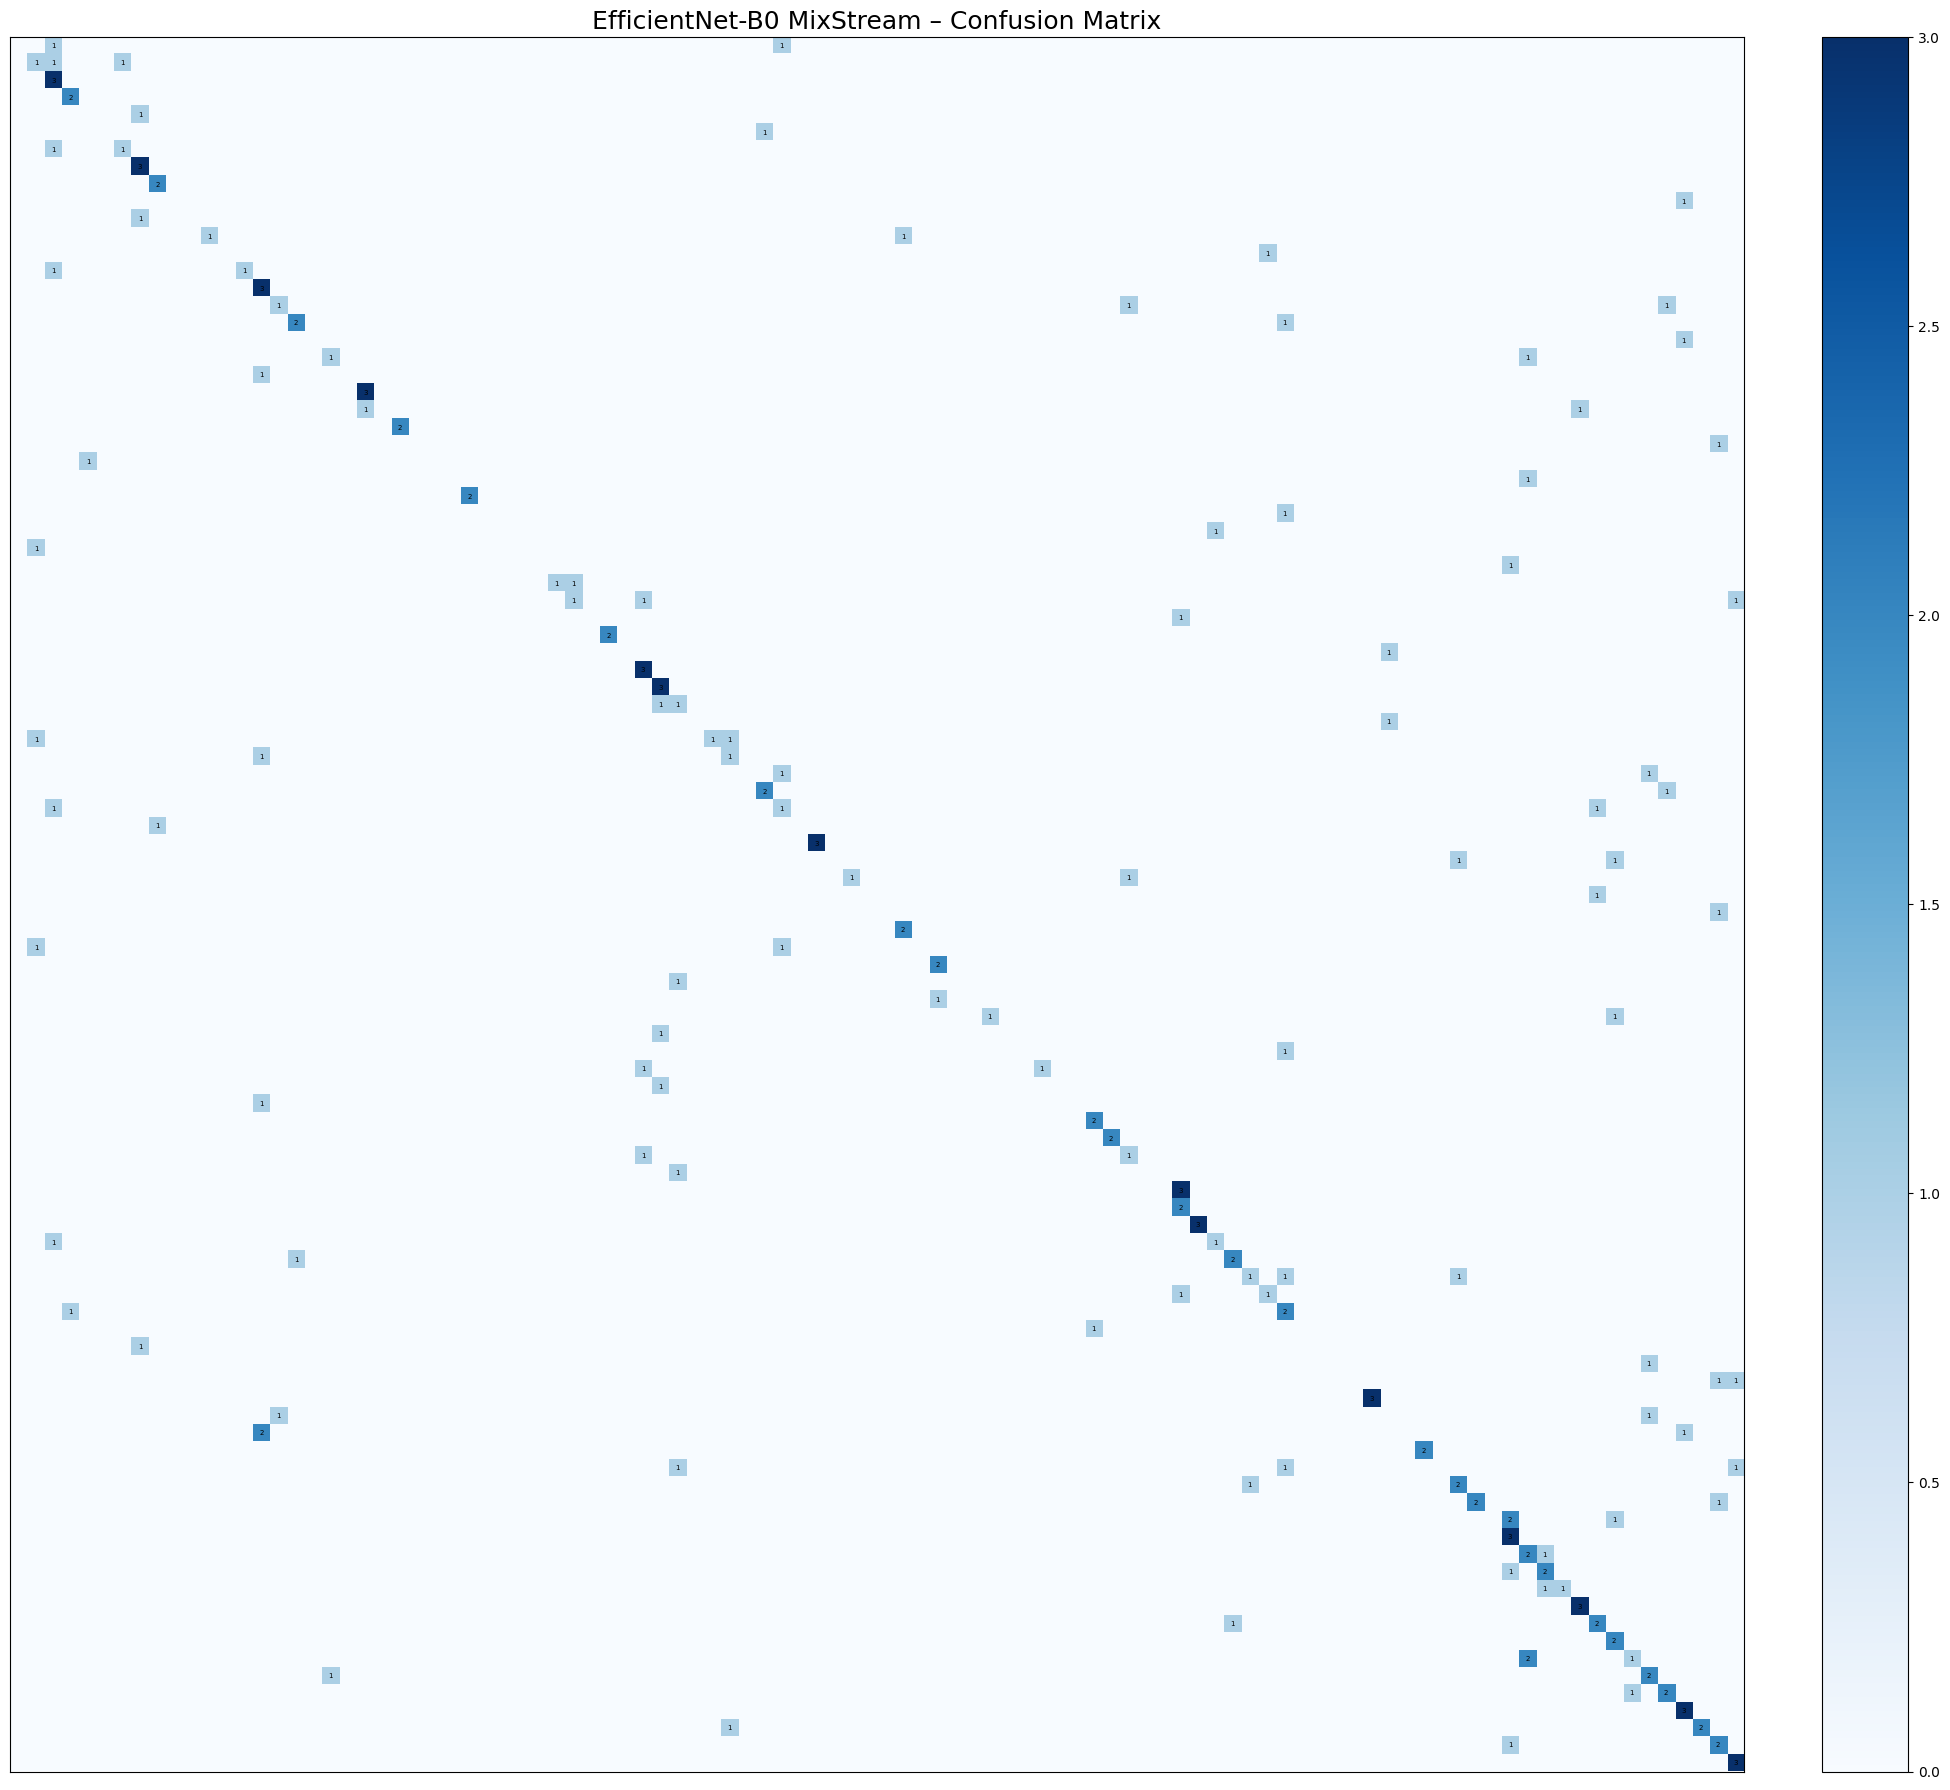


Showing EfficientNet-B0 predictions:


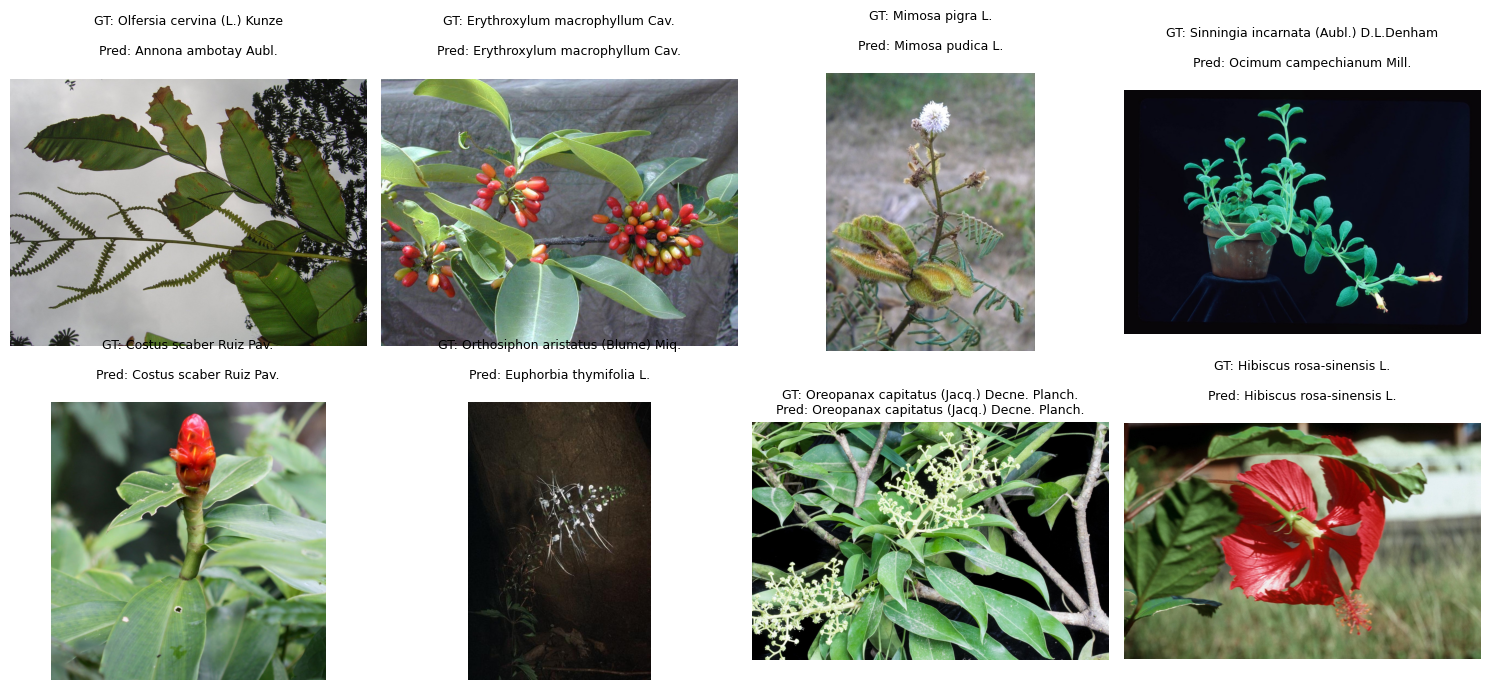

In [33]:
probs, pred1, pred5, top1, top5 = evaluate_model(
    model_eff, test_paths, test_labels
)

test_ds = make_test(test_paths, pre_eff)
loss = model_eff.evaluate(test_ds, verbose=0)[0]

print(f"\n=== EfficientNet-B0 MixStream Results ===")
print(f"Loss   : {loss:.4f}")
print(f"Top-1  : {top1*100:.2f}%")
print(f"Top-5  : {top5*100:.2f}%")

pair1, pair5, nopair1, nopair5 = compute_pair_accuracy(pred1, pred5, test_labels)

print("\nPair / No-Pair Accuracy:")
print(f"Pair Top-1: {pair1*100:.2f}%")
print(f"Pair Top-5: {pair5*100:.2f}%")
print(f"NoPair Top-1: {nopair1*100:.2f}%")
print(f"NoPair Top-5: {nopair5*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(test_labels, pred1)

plt.figure(figsize=(20, 18))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("EfficientNet-B0 MixStream – Confusion Matrix", fontsize=18)

# Remove dense labels (too many classes)
plt.xticks([])
plt.yticks([])

# Write values inside matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        v = cm[i, j]
        if v > 0:
            plt.text(j, i, str(v), ha='center', va='center',
                     fontsize=5, color='black')

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

show_examples(test_paths, test_labels, pred1, "EfficientNet-B0")


In [34]:
# Preprocess
pre_res = tf.keras.applications.resnet.preprocess_input

train_ds = make_train(train_paths, train_labels, pre_res)
test_ds  = make_test(test_paths, pre_res)

res_base = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
res_base.trainable = False

inp = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = res_base(inp, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

b1 = tf.keras.layers.Dense(512, activation="relu")(x)
b1 = tf.keras.layers.Dropout(0.5)(b1)

b2 = tf.keras.layers.Dense(256, activation="relu")(x)
b2 = tf.keras.layers.Dropout(0.3)(b2)

merged = tf.keras.layers.Concatenate()([b1, b2])
out = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(merged)

model_res = tf.keras.Model(inp, out)

model_res.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ]
)

history3 = model_res.fit(train_ds, epochs=20)

# Fine-tune last 120 layers
for layer in res_base.layers[-120:]:
    layer.trainable = True

model_res.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name="top1"),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top5"),
    ]
)

history4 = model_res.fit(train_ds, epochs=10)


Epoch 1/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 53s 278ms/step - loss: 4.5036 - top1: 0.0827 - top5: 0.2368
Epoch 2/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - loss: 3.1696 - top1: 0.2368 - top5: 0.4877
Epoch 3/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - loss: 2.4923 - top1: 0.3781 - top5: 0.6395
Epoch 4/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 236ms/step - loss: 2.1996 - top1: 0.4330 - top5: 0.7231
Epoch 5/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 241ms/step - loss: 1.8817 - top1: 0.4915 - top5: 0.7736
Epoch 6/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - loss: 1.6919 - top1: 0.5473 - top5: 0.8105
Epoch 7/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - loss: 1.5219 - top1: 0.5749 - top5: 0.8506
Epoch 8/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 38s 254ms/step - loss: 1.3527 - top1: 0.6188 - top5: 0.8678
Epoch 9/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 247ms/step - loss: 1.2636 - top1: 0.6359 - top5: 0.8723
Epoch 10/20
149/149 ━━━━━━━━━━━━━━━━━━━━ 37s 245ms/step - loss: 1.1383 - top1: 0.6762 - top5: 0.8990

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 946ms/step

=== ResNet50 MixStream Results ===
Loss   : 5.1244
Top-1  : 49.76%
Top-5  : 63.77%

Pair / No-Pair Accuracy:
Pair Top-1: 67.32%
Pair Top-5: 86.27%
NoPair Top-1: 0.00%
NoPair Top-5: 0.00%


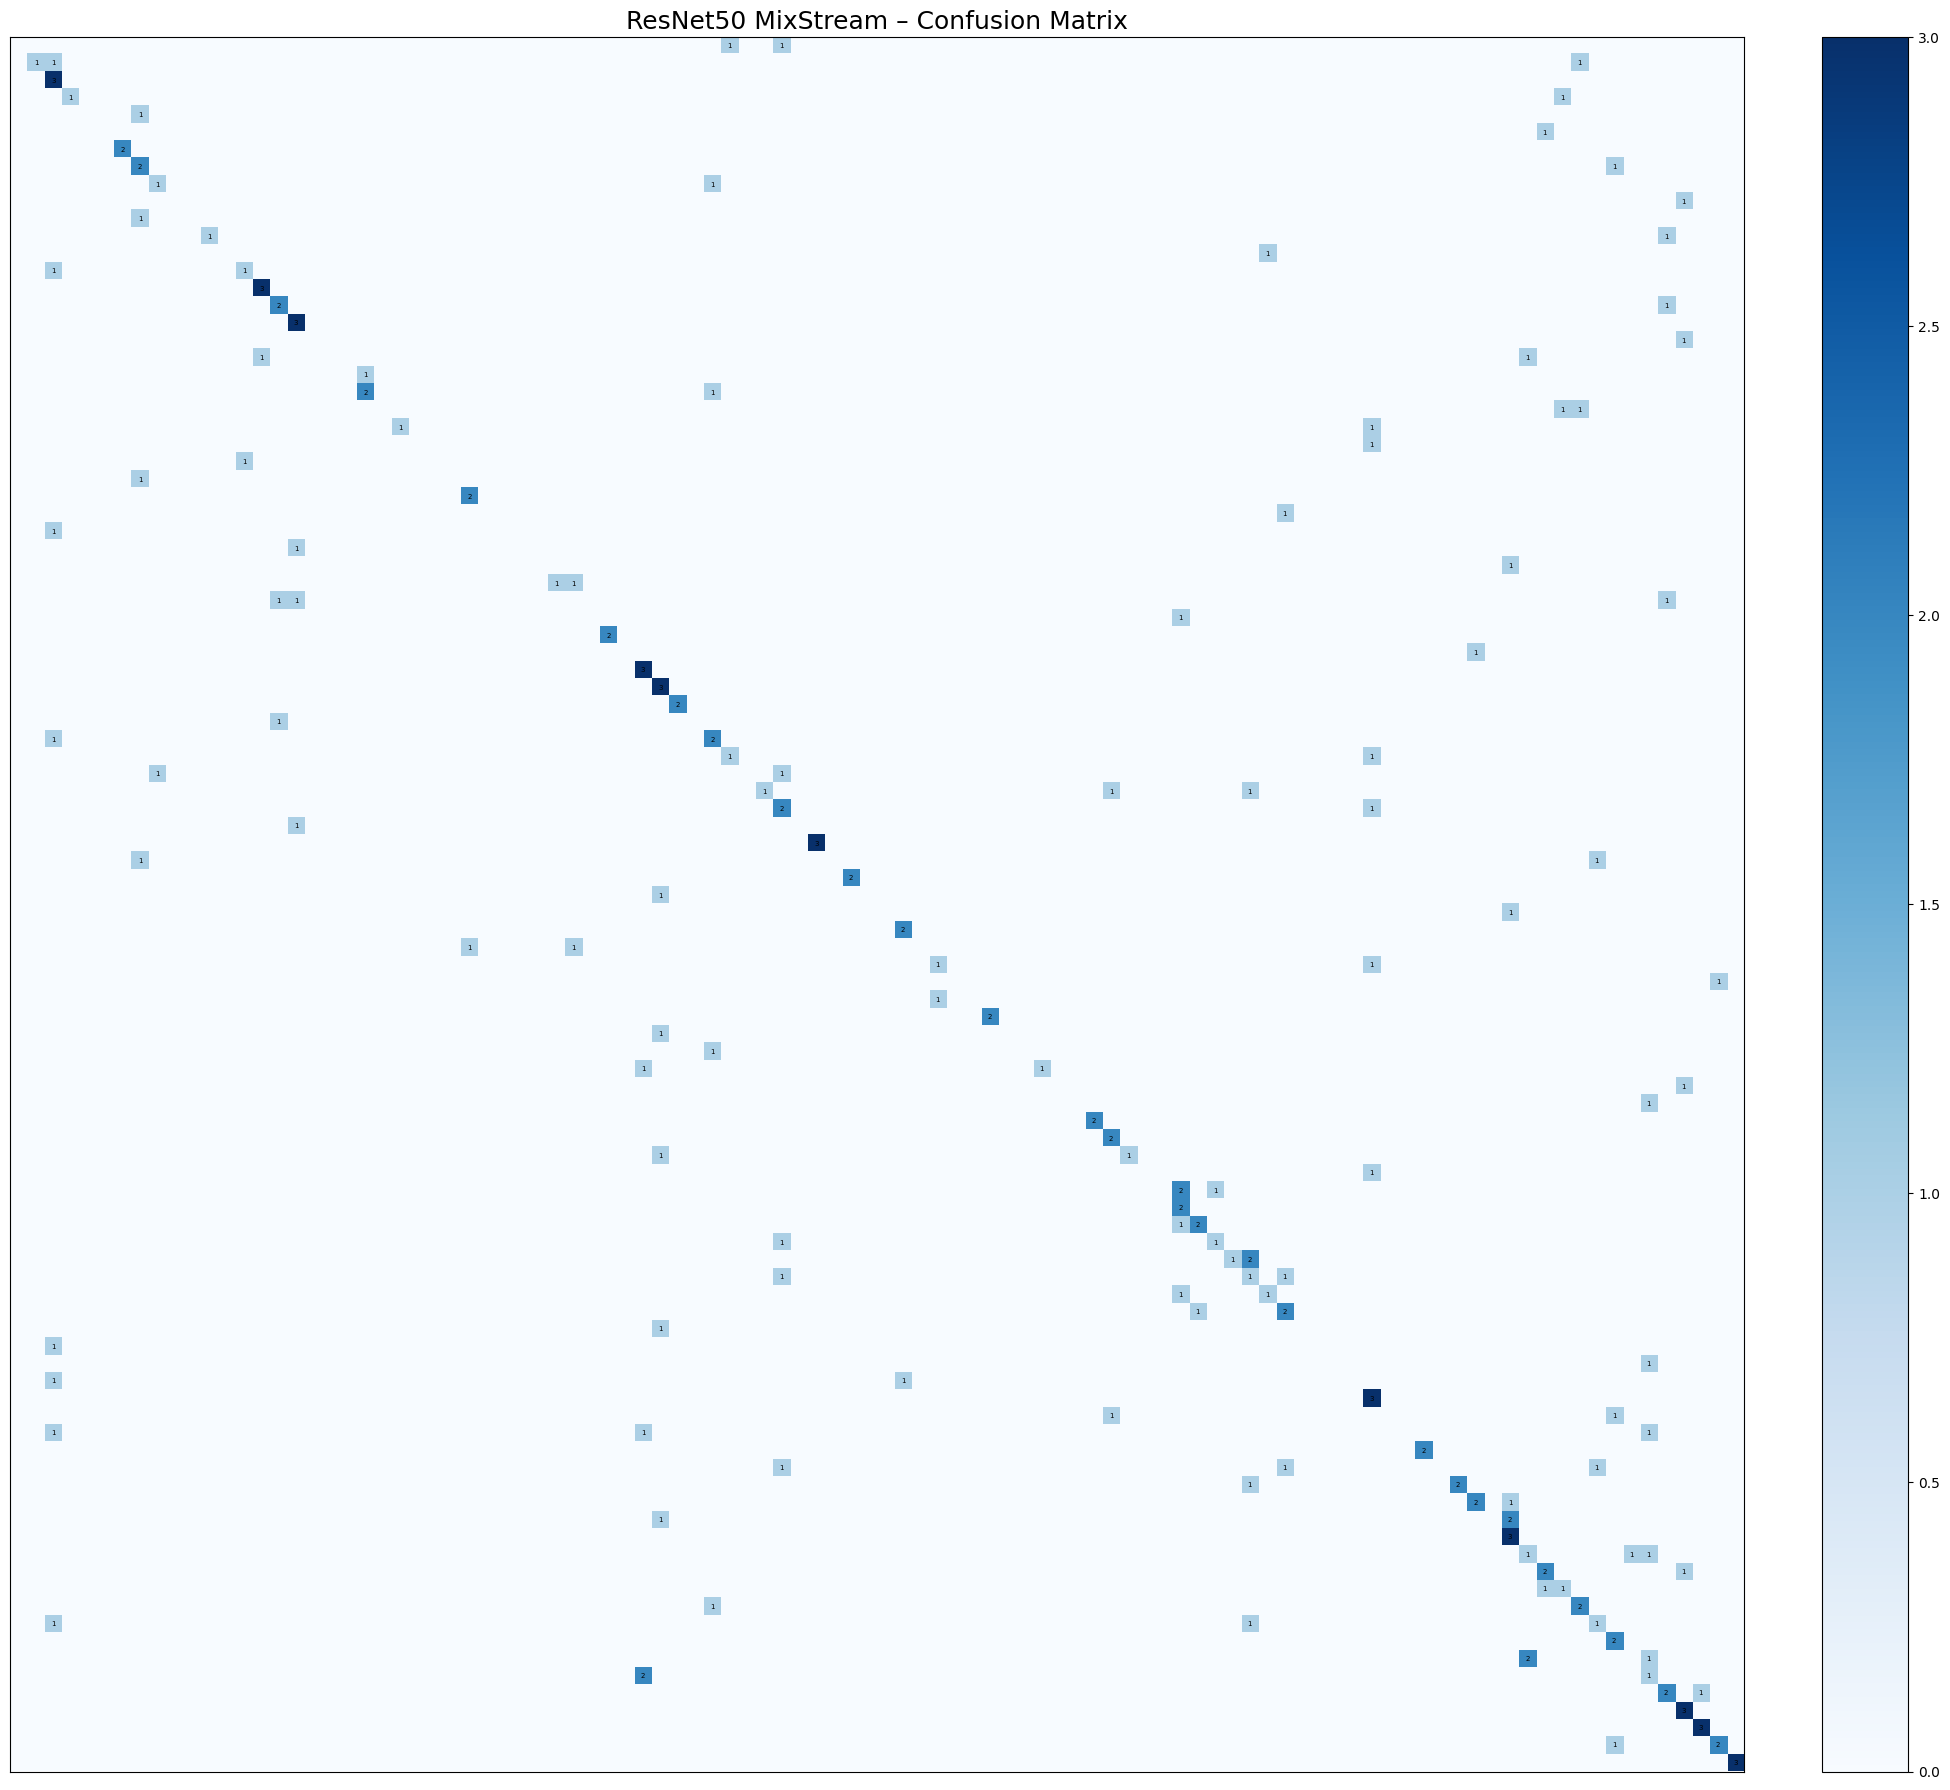


Showing ResNet50 predictions:


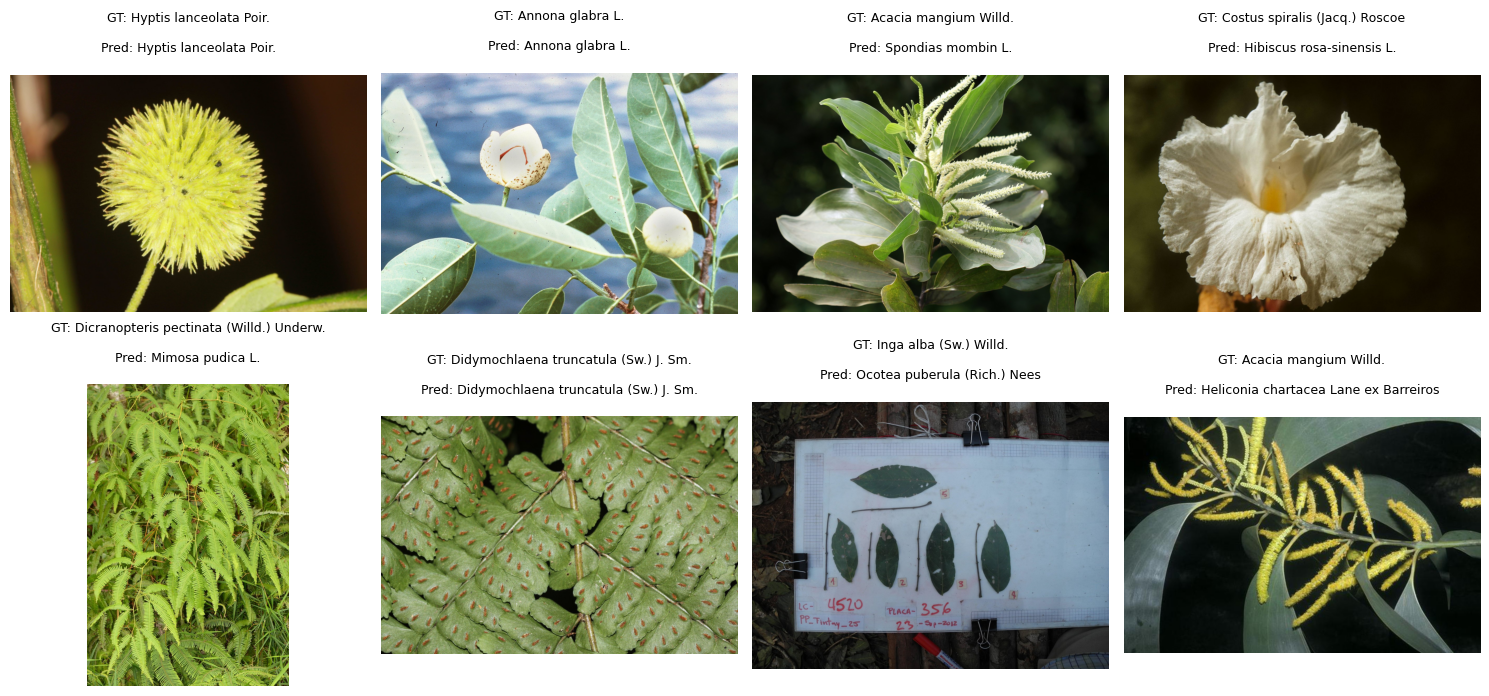

In [35]:
probs, pred1_r, pred5_r, top1_r, top5_r= evaluate_model(
    model_res, test_paths, test_labels
)
test_ds = make_test(test_paths, pre_res)
loss = model_res.evaluate(test_ds, verbose=0)[0]

print(f"\n=== ResNet50 MixStream Results ===")
print(f"Loss   : {loss:.4f}")
print(f"Top-1  : {top1_r*100:.2f}%")
print(f"Top-5  : {top5_r*100:.2f}%")

pair1_r, pair5_r, nopair1_r, nopair5_r = compute_pair_accuracy(pred1_r, pred5_r, test_labels)

print("\nPair / No-Pair Accuracy:")
print(f"Pair Top-1: {pair1_r*100:.2f}%")
print(f"Pair Top-5: {pair5_r*100:.2f}%")
print(f"NoPair Top-1: {nopair1_r*100:.2f}%")
print(f"NoPair Top-5: {nopair5_r*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, pred1_r)

plt.figure(figsize=(20, 18))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("ResNet50 MixStream – Confusion Matrix", fontsize=18)

plt.xticks([])
plt.yticks([])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        v = cm[i, j]
        if v > 0:
            plt.text(j, i, str(v), ha='center', va='center',
                     fontsize=5, color='black')

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

show_examples(test_paths, test_labels, pred1_r, "ResNet50")
